In [ ]:
!git clone https://github.com/pearsonlab/POISE-VAE-JAX.git

fatal: destination path 'POISE-VAE-JAX' already exists and is not an empty directory.


In [ ]:
import sys, os
sys.path.append(os.getcwd() + '/POISE-VAE-JAX')

In [ ]:
!pip install flax

In [ ]:
import jax.numpy as jnp
from jax import jit, grad, random, vmap, custom_jvp, value_and_grad
from jax.numpy import concatenate
from jax.lax import scan
import flax.linen as nn
import jax.scipy.stats as stats
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
# "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]
})

sns.set_context('talk')
%config InlineBackend.figure_format='retina'

In [ ]:
@jit
def gaussian_sample(rng, mu, sigmasq):
  """Sample a diagonal Gaussian."""
  return mu + jnp.sqrt(sigmasq) * random.normal(rng, mu.shape)

CPU times: user 411 ms, sys: 9.46 ms, total: 421 ms
Wall time: 489 ms


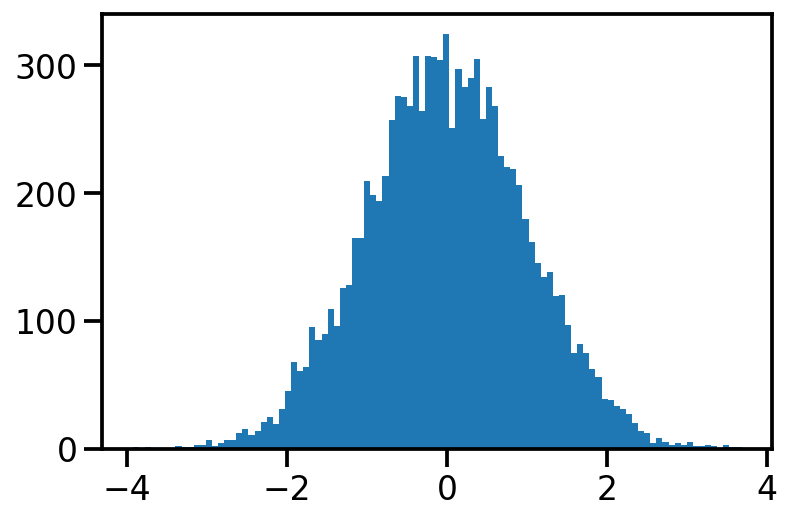

In [ ]:
test_rng = random.PRNGKey(1)

mu = jnp.zeros(10000)
var = 1

%time sample = gaussian_sample(test_rng, mu, var)

plt.hist(sample, bins=100);

In [ ]:
@jit
def pack_T(z):
  """
  Calculate and return sufficient statistics given z and z'
  """
  T = jnp.stack((z, z * z), axis=-1)
  return T

@jit
def log_q(Tz, Tzp, t, g, nu, nup):
  """
  calculate log UNNORMALIZED posterior
  Tz: D x K input
  Tzp: D x K input (z')
  t: D x K input of base measure
  g: D x D x K x K prior coupling 
  nu: D x K likelihood sufficient statistics
  nup: D x K likelihood sufficient statistics (nu')
  """
  base = jnp.sum(Tz * t) + jnp.sum(Tzp * t)
  prior = jnp.einsum('ijkl,ik,jl', g, Tz, Tzp)
  likelihood = jnp.sum(Tz * nu) + jnp.sum(Tzp * nup)
  return base + prior + likelihood

@jit
def log_p(Tz, Tzp, t, g):
  """
  Calculate log UNNORMALIZED prior
  """
  return log_q(Tz, Tzp, t, g, 0, 0)

In [ ]:
@jit
def calc_conditional(Tzp, t, g, nu):
  """
  Calculate conditional parameters of the distribution on z (mean, variance)
  given T(z'), t, nu, and g.
  Return shape is B x D x K
  """
  Teff = t + nu + jnp.einsum('ijkl, jl', g, Tzp)
  var = -0.5 / Teff[:, 1]
  mean = Teff[:, 0] * var
  return mean, var


In [ ]:
B, D, K = 10, 5, 2
zkey, zpkey, nukey, nupkey, gkey = random.split(test_rng, 5)
z = random.normal(zkey, (D,))
zp = random.normal(zpkey, (D,))
Tz = pack_T(z)
Tzp = pack_T(zp)
nu = random.normal(nukey, (D, K))
nup = random.normal(nupkey, (D, K))
g = random.normal(gkey, (D, D, K, K))
t = jnp.stack([jnp.zeros(D), -0.5 * jnp.ones(D)], axis=1)

log_q(Tz, Tzp, t, g, nu, nup)
log_p(Tz, Tzp, t, g)
mean, var = calc_conditional(Tzp, t, g, nu)

Try some `vmap` over arrays for `log_q`:

In [ ]:
z = random.normal(zkey, (B, D))
zp = random.normal(zpkey, (B, D))
Tz = vmap(pack_T)(z)
Tzp = vmap(pack_T)(zp)
nu = random.normal(nukey, (B, D, K))
nup = random.normal(nupkey, (B, D, K))

v_log_q = vmap(log_q, (0, 0, None, None, 0, 0), 0)
v_log_q(Tz, Tzp, t, g, nu, nup)

@jit
def cond_sample(rng, Tzp, t, g, nu):
  mean, var = calc_conditional(Tzp, t, g, nu)
  return gaussian_sample(rng, mean, var)

v_cond_sample = vmap(cond_sample, (None, 0, None, None, 0), 0)
v_cond_sample(test_rng, Tz, t, g, nu).shape

(10, 5)

# Let's try some Gibbs sampling

In [ ]:
D, K = 1, 2  # dimensions, sufficient statistics

Let's plot the prior
$$
p(z, z') \propto \exp\left(-\frac{z^2}{2} - \frac{(z')^2}{2} + 4 z z' - z^2 (z')^2 \right)
$$

In [ ]:
t = jnp.asarray(np.tile([0 , -0.5], (D, 1)))
g = jnp.asarray(np.tensordot(np.eye(D), [[4, 0], [0, -1]], axes=0))

print(t.shape, g.shape, nu.shape)

(1, 2) (1, 1, 2, 2) (10, 5, 2)


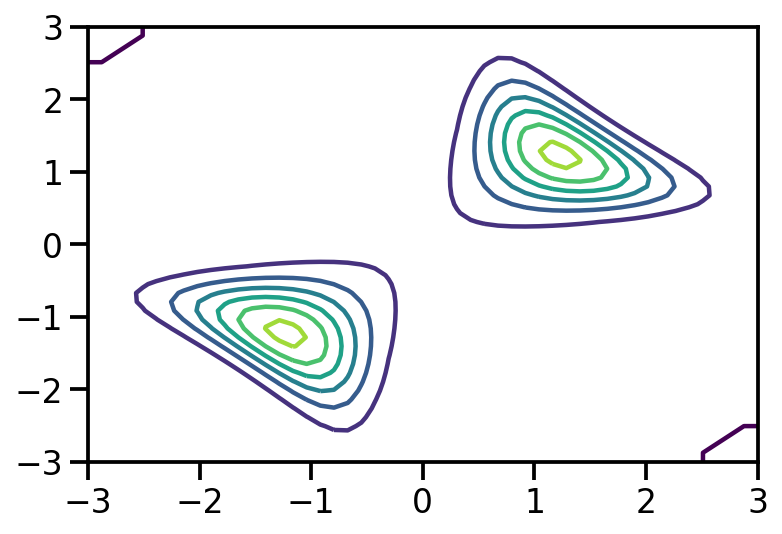

In [ ]:
# this only evaluates the contour for the *first* components of z and z',
# effectively setting all others to 0

xx = jnp.linspace(-3, 3, 50)
X, Y = jnp.meshgrid(xx, xx)
plotfun = vmap(vmap(lambda z, zp: jnp.exp(log_p(pack_T(z), pack_T(zp), t, g))))
Z = plotfun(jnp.expand_dims(X, -1), jnp.expand_dims(Y, -1))
plt.contour(X, Y, Z);

Intialize the chain and alternate draws of $z$ and $z'$:

In [ ]:
rng = random.PRNGKey(0)
niter = 100
nu = 0
nup = 0

def gibbs_sample(rng, niter, t, g, nu, nup):
  chains = np.empty((niter, D, 2))
  z_init_key, zp_init_key, rng = random.split(rng, 3)
  z_init = cond_sample(z_init_key, jnp.zeros((D, K)), t, jnp.zeros((D, D, K, K)), nu)
  zp_init = cond_sample(zp_init_key, jnp.zeros((D, K)), t, jnp.zeros((D, D, K, K)), nup)
  chains[0] = np.stack([z_init, zp_init], axis=-1)
  Tz = pack_T(chains[0, :, 0])
  Tzp = pack_T(chains[0, :, 1])

  for idx in range(1, niter):
    z_key, zp_key, rng = random.split(rng, 3)
    z = cond_sample(z_key, Tzp, t, g, nu)
    Tz = pack_T(z)
    zp = cond_sample(zp_key, Tz, t, g, nup)
    Tzp = pack_T(zp)

    chains[idx] = np.stack((z, zp), axis=-1)

  return chains

@jit
def gibbs_single_sample(carry, x=None):
  rng, z0, zp0, t, g, nu, nup = carry
  z_key, zp_key, rng = random.split(rng, 3)
  Tz = pack_T(z0)
  Tzp = pack_T(zp0)
  z = cond_sample(z_key, Tzp, t, g, nu)
  Tz = pack_T(z)
  zp = cond_sample(zp_key, Tz, t, g, nup)
  Tzp = pack_T(zp)
  return (rng, z, zp, t, g, nu, nup), jnp.stack([z, zp], axis=-1)


def gibbs_sample_scan(rng, niter, t, g, nu, nup):
  z_init_key, zp_init_key, rng = random.split(rng, 3)
  z_init = cond_sample(z_init_key, jnp.zeros((D, K)), t, jnp.zeros((D, D, K, K)), nu)
  zp_init = cond_sample(zp_init_key, jnp.zeros((D, K)), t, jnp.zeros((D, D, K, K)), nup)
  init = (rng, z_init, zp_init, t, g, nu, nup)

  _, chains = scan(gibbs_single_sample, init, None, niter)

  return chains


In [ ]:
%time chains = gibbs_sample_scan(rng, niter, t, g, nu, nup).block_until_ready()
%time chains = gibbs_sample(rng, niter, t, g, nu, nup)

CPU times: user 1.87 s, sys: 17 ms, total: 1.89 s
Wall time: 2.67 s
CPU times: user 48.1 ms, sys: 0 ns, total: 48.1 ms
Wall time: 62.6 ms


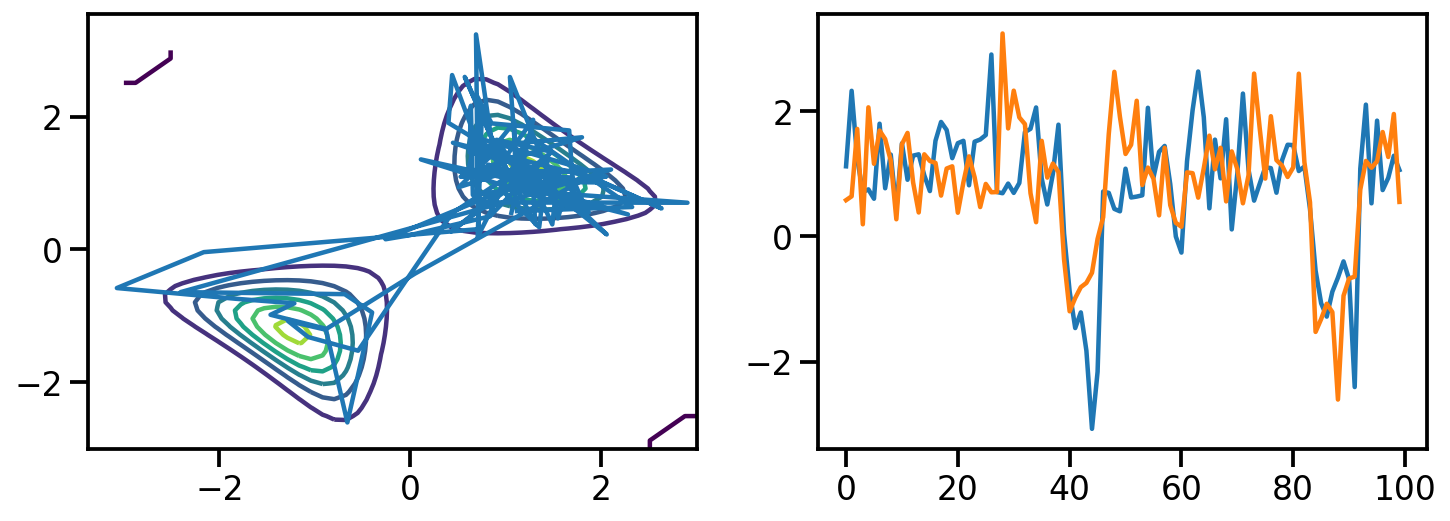

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].contour(X, Y, Z)
axs[0].plot(chains[:, 0, 0], chains[:, 0, 1])
axs[1].plot(chains.reshape(niter, -1));

Let's try with the posterior:
$$
p(z, z') \propto \exp\left(\sum_j -\frac{z_j^2}{2} - \frac{(z_j')^2}{2} + 4 z_j z'_j - z_j^2 (z'_j)^2 + \nu_1 z_j + \nu_2 z_j^2 + \nu_1' z'_j + \nu_2' (z'_j)^2\right)
$$

In [ ]:
D, K = 16, 2

In [ ]:
t = jnp.asarray(np.tile([0 , -0.5], (D, 1)))
g = jnp.asarray(np.tensordot(np.eye(D), [[4, 0], [0, -1]], axes=0))

nu_mean, nu_std = -5, .1
nu = jnp.asarray(np.tile([nu_mean/nu_std**2, -0.5/nu_std**2], (D, 1)))

nup_mean, nup_std = -1, 0.2
nup = jnp.asarray(np.tile([nup_mean/nup_std**2, -0.5/nu_std**2], (D, 1)))

print(t.shape, g.shape, nu.shape)

(16, 2) (16, 16, 2, 2) (16, 2)


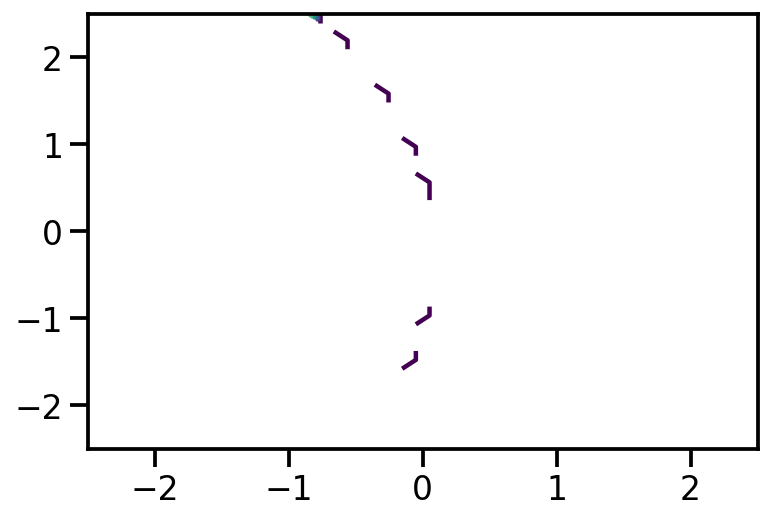

In [ ]:
# this only evaluates the contour for the *first* components of z and z',
# effectively setting all others to 0
# so this doesn't mean much for where the density is!

xx = jnp.linspace(-2.5, 2.5, 50)
X, Y = jnp.meshgrid(xx, xx)
plotfun = vmap(vmap(lambda z, zp: jnp.exp(log_q(pack_T(z), pack_T(zp), t, g, nu, nup))))
Z = plotfun(jnp.expand_dims(X, -1), jnp.expand_dims(Y, -1))
plt.contour(X, Y, Z);

In [ ]:
rng = random.PRNGKey(0)
niter = 100

%time chains = gibbs_sample_scan(rng, niter, t, g, nu, nup).block_until_ready()
%time chains = gibbs_sample(rng, niter, t, g, nu, nup)

CPU times: user 2.97 s, sys: 30.1 ms, total: 3 s
Wall time: 4.3 s
CPU times: user 46.6 ms, sys: 33 µs, total: 46.6 ms
Wall time: 70.5 ms


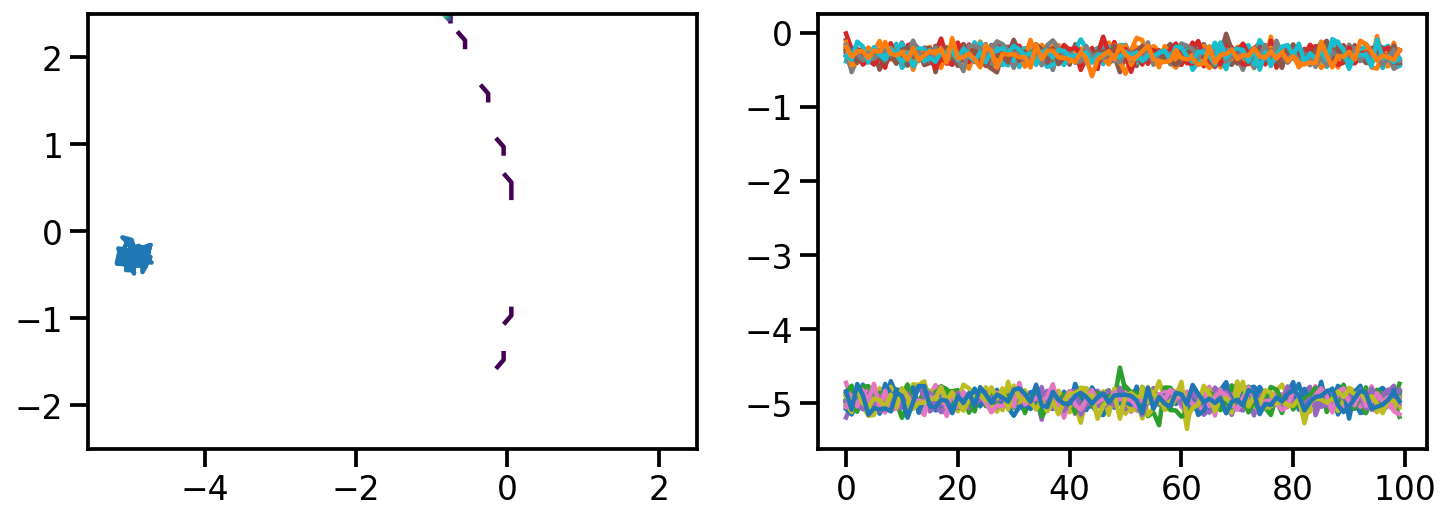

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].contour(X, Y, Z)
axs[0].plot(chains[:, 0, 0], chains[:, 0, 1])
axs[1].plot(chains.reshape(niter, -1));

# Calculating KL gradients

We want to use Monte-Carlo to estimate gradients of the KL divergence as specified in the notes:

$$
\nabla_g D_{KL}(q \Vert p) = (\mathbb{E}_p - \mathbb{E}_q)[\mathbf{T} \otimes \mathbf{T}']
$$

In [ ]:
# let's run some chains

rng = random.PRNGKey(0)
niter = 100

chains_p = gibbs_sample_scan(rng, niter, t, g, 0, 0)
chains_q = gibbs_sample_scan(rng, niter, t, g, nu, nup)

In [ ]:
chains_p.shape

(100, 16, 2)

In [ ]:
Tz_p = vmap(pack_T)(chains_p[:, : , 0]).reshape((niter, -1), order='F')
Tzp_p = vmap(pack_T)(chains_p[:, : , 1]).reshape((niter, -1), order='F')
Tz_q = vmap(pack_T)(chains_q[:, : , 0]).reshape((niter, -1), order='F')
Tzp_q = vmap(pack_T)(chains_q[:, : , 1]).reshape((niter, -1), order='F')

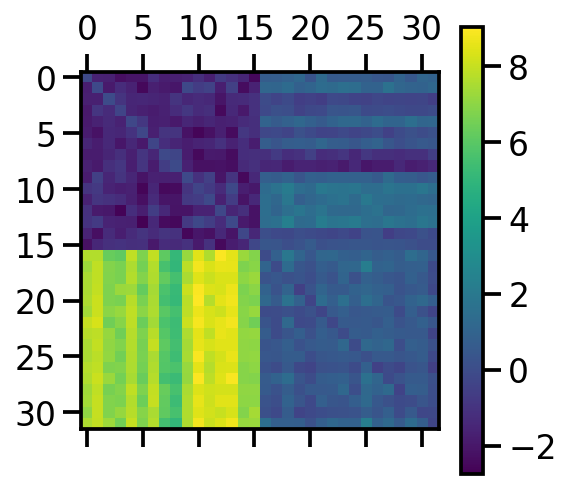

In [ ]:
TTp_p = jnp.tensordot(Tz_p, Tzp_p, axes=(0, 0))/niter
TTp_q = jnp.tensordot(Tz_q, Tzp_q, axes=(0, 0))/niter
plt.matshow(TTp_p - TTp_q)
plt.colorbar()

and also
$$
\nabla_\nu D_{KL}(q\Vert p) = \langle \boldsymbol{\nu}, \mathrm{cov}_q[\mathbf{T}] \rangle
$$

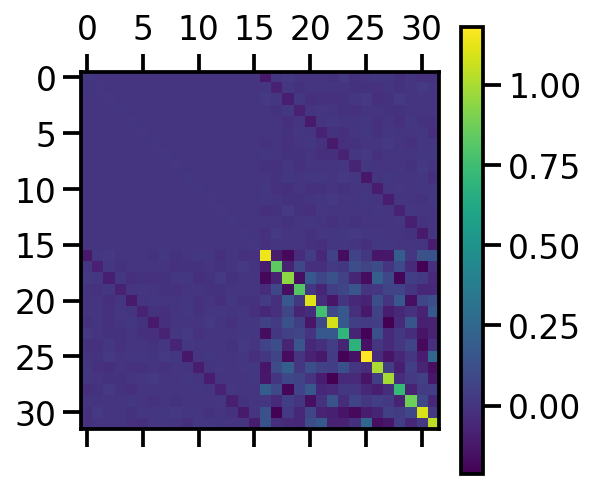

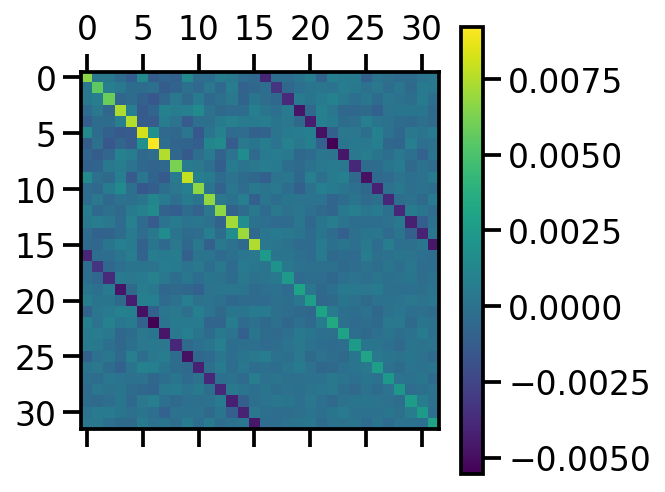

In [ ]:
covT_q = jnp.cov(Tz_q, rowvar=False)
covTp_q = jnp.cov(Tzp_q, rowvar=False)
plt.matshow(covT_q)
plt.colorbar()
plt.matshow(covTp_q)
plt.colorbar()

In [ ]:
nu_flat = nu.ravel(order='F')
nup_flat = nup.ravel(order='F')

In [ ]:
nu_flat @ covT_q

DeviceArray([-0.06592534, -0.090863  ,  0.02387005, -0.04357125,
              0.0308256 , -0.00551755, -0.0488449 , -0.05096401,
             -0.00711107, -0.08158369, -0.07479265, -0.02505944,
             -0.0454197 , -0.05781583,  0.01534461, -0.01497847,
              0.6463479 ,  0.8676833 , -0.2445099 ,  0.4270146 ,
             -0.32162392,  0.05218723,  0.47934636,  0.5031367 ,
              0.06270288,  0.8036256 ,  0.7351855 ,  0.237798  ,
              0.44031644,  0.56576574, -0.16773362,  0.14015627],            dtype=float32)

In [ ]:
nup_flat @ covTp_q

DeviceArray([ 0.03075917,  0.02207196,  0.0279379 ,  0.05627139,
              0.02085185,  0.02425504, -0.00557979,  0.05376123,
              0.01782412,  0.05006971,  0.05507345,  0.02660717,
             -0.02154232,  0.05418588,  0.03900962,  0.02457808,
             -0.01767216, -0.01677062, -0.02237605, -0.04113571,
             -0.01673367, -0.02228638, -0.00182303, -0.03684528,
             -0.01681633, -0.03783673, -0.0390361 , -0.01849426,
              0.00732137, -0.03695183, -0.03104945, -0.01804671],            dtype=float32)

wrap it all up into a function

In [ ]:
def DKL_gradients(rng, niter, t, g, nu, nup):
  # get sample chains
  chains_p = gibbs_sample_scan(rng, niter, t, g, 0, 0)
  chains_q = gibbs_sample_scan(rng, niter, t, g, nu, nup)

  # calculate sufficient statistics
  Tz_p = vmap(pack_T)(chains_p[:, : , 0])
  Tzp_p = vmap(pack_T)(chains_p[:, : , 1])
  Tz_q = vmap(pack_T)(chains_q[:, : , 0])
  Tzp_q = vmap(pack_T)(chains_q[:, : , 1])

  # calculate expectations
  TTp_p = jnp.tensordot(Tz_p, Tzp_p, axes=(0, 0)).transpose(0, 2, 1, 3)/niter
  TTp_q = jnp.tensordot(Tz_q, Tzp_q, axes=(0, 0)).transpose(0, 2, 1, 3)/niter
  g_grad = (TTp_p - TTp_q)

  covT_q = jnp.cov(Tz_q.reshape(niter, -1), rowvar=False)
  covTp_q = jnp.cov(Tzp_q.reshape(niter, -1), rowvar=False)
  nu_grad = (nu.ravel() @ covT_q).reshape(nu.shape)
  nup_grad = (nup.ravel() @ covTp_q).reshape(nup.shape)

  return g_grad, nu_grad, nup_grad

In [ ]:
DKL_gradients(rng, niter, t, g, nu, nup);

In [ ]:
@partial(custom_jvp, nondiff_argnums=(0, 1))
def DKL(rng, t, g, nu, nup):
  return 0.

@DKL.defjvp
def DKL_jvp(rng, t, primals, tangents):
  g, nu, nup = primals
  g_dot, nu_dot, nup_dot = tangents
  primal_out = DKL(rng, t, g, nu, nup)
  g_grad, nu_grad, nup_grad = DKL_gradients(rng, niter, t, g, nu, nup)
  tangent_out = jnp.sum(g_grad * g_dot) + jnp.sum(nu_grad * nu_dot) + jnp.sum(nup_grad * nup_dot)
  return primal_out, tangent_out



In [ ]:
value_and_grad(DKL, argnums=range(2, 5))(rng, t, g, nu, nup);

## Full ELBO
Since the reconstruction and the KL loss should use the same samples, we either need to pass the samples around or just encapsulate that inside a single ELBO loss

In [ ]:
def log_recon_pdf(x, mean, var):
  # log pdf of reconstruction loss
  return (-0.5 * jnp.sum((x - mean)**2)/var)/mean.shape[0] - 0.5 * x.shape[0] * jnp.log(2 * jnp.pi * var)

In [ ]:
xdim = 50
x = random.normal(rng, (xdim,))
mean = random.normal(rng, (niter, xdim))
var = 0.01

@jit
def log_recon_pdf(x, mean, var):
  return stats.norm.logpdf(x, mean, jnp.sqrt(var)).sum(1).mean()

print(log_recon_pdf(x, mean, var).shape)
%time log_recon_pdf(x, mean, var)

()
CPU times: user 136 µs, sys: 5 µs, total: 141 µs
Wall time: 103 µs


DeviceArray(-4372.431, dtype=float32)

In [ ]:
A = random.normal(rng, (xdim, D))

def decoder(z):
  return A @ z

chains_p = gibbs_sample_scan(rng, niter, t, g, 0, 0)
chains_q = gibbs_sample_scan(rng, niter, t, g, nu, nup)
x_recons = vmap(decoder)(chains_q[:, :, 0])

In [ ]:
@partial(custom_jvp, nondiff_argnums=(0, 1, 4))
def recon(q_samples, x, x_recons, var, t, g, nu, nup):
  return log_recon_pdf(x, x_recons, var)

@recon.defjvp
def recon_jvp(q_samples, x, t, primals, tangents):
  x_recons, var, g, nu, nup = primals
  x_recons_dot, var_dot, g_dot, nu_dot, nup_dot = tangents

  # calculate sufficient statistics
  Tz_q = vmap(pack_T)(q_samples[:, : , 0])
  Tzp_q = vmap(pack_T)(q_samples[:, : , 1])
  logp = log_recon_pdf(x, x_recons, var).reshape(-1, 1, 1)

  # calculate gradients wrt encoder params
  g_grad = jnp.tensordot(Tz_q, Tzp_q * logp, axes=(0, 0)).transpose(0, 2, 1, 3)/niter
  nu_grad = jnp.mean(Tz_q * logp, axis=0)
  nup_grad = jnp.mean(Tzp_q * logp, axis=0)

  # gradients wrt to decoder params
  x_recons_grad, var_grad = grad(log_recon_pdf, argnums=(1, 2))(x, x_recons, var)

  primal_out = recon(q_samples, x, x_recons, var, t, g, nu, nup)

  tangent_out = (jnp.sum(g_grad * g_dot) + jnp.sum(nu_grad * nu_dot) + 
                 jnp.sum(nup_grad * nup_dot) + 
                 jnp.sum(x_recons_grad * x_recons_dot) +
                 jnp.sum(var_grad * var_dot))
  
  return primal_out, tangent_out

In [ ]:
val, grads = value_and_grad(recon, argnums=(2, 3, 5, 6, 7))(chains_q, x, x_recons, var, t, g, nu, nup)
print(val)
for gr in grads:
  print(gr.shape)

-951380.2
(100, 50)
()
(16, 16, 2, 2)
(16, 2)
(16, 2)


In [ ]:
def DKL_gradients(chains_p, chains_q, t, g, nu, nup):
  # calculate sufficient statistics
  Tz_p = vmap(pack_T)(chains_p[:, : , 0])
  Tzp_p = vmap(pack_T)(chains_p[:, : , 1])
  Tz_q = vmap(pack_T)(chains_q[:, : , 0])
  Tzp_q = vmap(pack_T)(chains_q[:, : , 1])

  # calculate expectations
  TTp_p = jnp.tensordot(Tz_p, Tzp_p, axes=(0, 0)).transpose(0, 2, 1, 3)/niter
  TTp_q = jnp.tensordot(Tz_q, Tzp_q, axes=(0, 0)).transpose(0, 2, 1, 3)/niter
  g_grad = (TTp_p - TTp_q)

  covT_q = jnp.cov(Tz_q.reshape(niter, -1), rowvar=False)
  covTp_q = jnp.cov(Tzp_q.reshape(niter, -1), rowvar=False)
  nu_grad = (nu.ravel() @ covT_q).reshape(nu.shape)
  nup_grad = (nup.ravel() @ covTp_q).reshape(nup.shape)

  return g_grad, nu_grad, nup_grad

In [ ]:
@partial(custom_jvp, nondiff_argnums=(0, 1, 2))
def DKL(p_samples, q_samples, t, g, nu, nup):
  return 0.

@DKL.defjvp
def DKL_jvp(p_samples, q_samples, t, primals, tangents):
  g, nu, nup = primals
  g_dot, nu_dot, nup_dot = tangents
  primal_out = DKL(q_samples, p_samples, t, g, nu, nup)
  g_grad, nu_grad, nup_grad = DKL_gradients(p_samples, q_samples, t, g, nu, nup)
  tangent_out = jnp.sum(g_grad * g_dot) + jnp.sum(nu_grad * nu_dot) + jnp.sum(nup_grad * nup_dot)
  return primal_out, tangent_out

In [ ]:
val, grads = value_and_grad(DKL, argnums=range(3, 5))(chains_p, chains_q, t, g, nu, nup);
print(val)
for gr in grads:
  print(gr.shape)

0.0
(16, 16, 2, 2)
(16, 2)
